# Why some compounds are colored: Conjugated bond chains

I did my PhD in optical spectroscopy.

https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Electronic_Spectroscopy/Electronic_Spectroscopy_Basics/What_Causes_Molecules_to_Absorb_UV_and_Visible_Light

> If you extend this to compounds with really massive delocalisation, the wavelength absorbed will eventually be high enough to be in the visible region of the spectrum, and the compound will then be seen as colored. A good example of this is the orange plant pigment, beta-carotene - present in carrots, for example.

> The more delocalization there is, the smaller the gap between the highest energy pi bonding orbital and the lowest energy pi anti-bonding orbital. To promote an electron therefore takes less energy in beta-carotene than in the cases we've looked at so far - because the gap between the levels is less.



![Molecules and their conjugated pi bonds](../images/molecules_and_conjugated.png)

*Attribution: [Conjugated Pi Bond Systems from LibreTexts](https://chem.libretexts.org/Courses/Nassau_Community_College/Organic_Chemistry_I_and_II/02%3A_Structure_and_Properties_of_Organic_Molecules/2.04%3A_2.4_Conjugated_Pi_Bond_Systems), remixed by me*

[Experimental database of optical properties of organic compounds](https://www.nature.com/articles/s41597-020-00634-8) from the year 2020

In [1]:
import math
from typing import Iterable

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import RDLogger
import numpy as np
import polars as pl
import polars.selectors as cs
import altair as alt
import latexify

In [2]:
# Suppress RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [3]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

## Find longest conjugated bond chain

In [4]:
# Find connected components in the conjugated bond subgraph
def find_connected_component(graph, start_bond, visited):
    stack = [start_bond]
    connected_component = []
    
    while stack:
        bond_idx = stack.pop()
        if bond_idx not in visited:
            visited.add(bond_idx)
            connected_component.append(bond_idx)
            
            # Add all neighbors to the stack for traversal
            for neighbor, is_connected in enumerate(graph[bond_idx]):
                if is_connected and neighbor not in visited:
                    stack.append(neighbor)
    
    return connected_component

In [5]:
def get_longest_conjugated_bond_chain(mol):
    # Create a list to store conjugated bond indices
    conjugated_bonds = [bond.GetIdx() for bond in mol.GetBonds() if bond.GetIsConjugated()]
    
    if not conjugated_bonds:
        return []  # No conjugated bonds found, return empty list
    
    # Build a subgraph of only conjugated bonds
    bond_matrix = np.zeros((len(conjugated_bonds), len(conjugated_bonds)), dtype=int)
    
    # Populate the bond adjacency matrix for conjugated bonds
    for i, bond_i in enumerate(conjugated_bonds):
        bond_i_obj = mol.GetBondWithIdx(bond_i)
        for j, bond_j in enumerate(conjugated_bonds):
            if i != j:
                bond_j_obj = mol.GetBondWithIdx(bond_j)
                # Check if two conjugated bonds share an atom
                if len(set([bond_i_obj.GetBeginAtomIdx(), bond_i_obj.GetEndAtomIdx()]) & 
                       set([bond_j_obj.GetBeginAtomIdx(), bond_j_obj.GetEndAtomIdx()])) > 0:
                    bond_matrix[i, j] = 1
                    bond_matrix[j, i] = 1

    # Initialize variables to store the longest conjugated bond chain
    visited = set()
    longest_bond_chain = []

    # Traverse the graph and find the largest connected component
    for start_bond in range(len(conjugated_bonds)):
        if start_bond not in visited:
            bond_chain = find_connected_component(bond_matrix, start_bond, visited)
            if len(bond_chain) > len(longest_bond_chain):
                longest_bond_chain = bond_chain

    # Convert subgraph bond indices back to the original bond indices
    conjugated_bonds_out = [conjugated_bonds[i] for i in longest_bond_chain]
    conjugated_bonds_out.sort()
    return conjugated_bonds_out

### Check that longest conjugated bond chain gives expected results

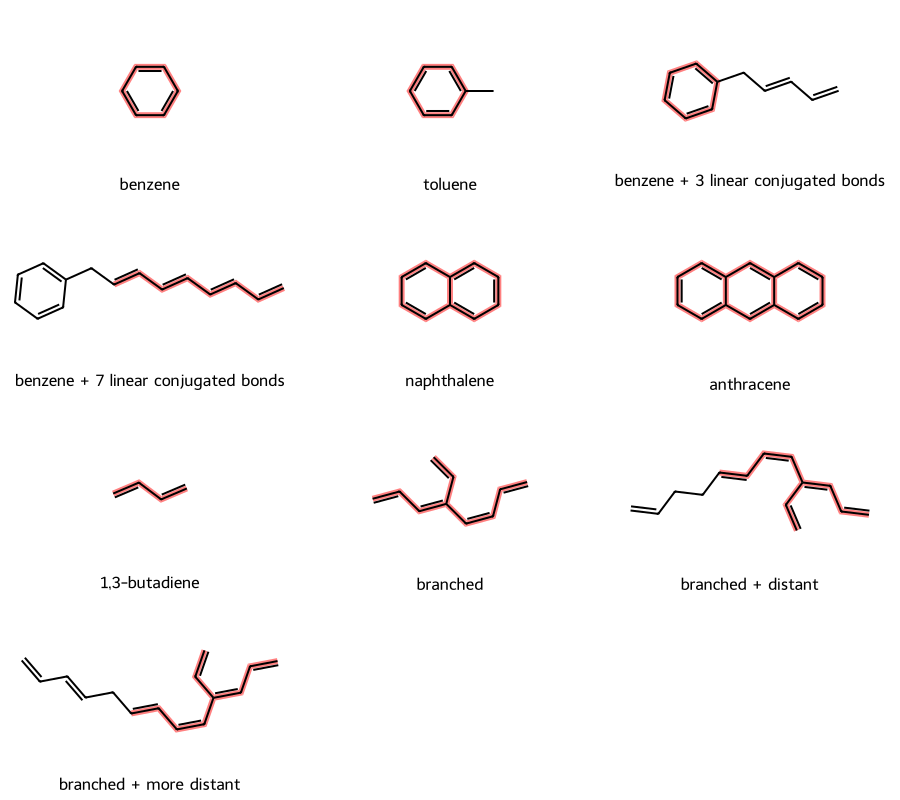

In [6]:
examples = {
    "benzene": "c1ccccc1",
    "toluene": "c1ccccc1C",
    "benzene + 3 linear conjugated bonds": "c1ccccc1CC=CC=C",
    "benzene + 7 linear conjugated bonds": "c1ccccc1CC=CC=CC=CC=C",
    "naphthalene": "c1c2ccccc2ccc1",
    "anthracene": "c1ccc2cc3ccccc3cc2c1",
    "1,3-butadiene": "C=CC=C",
    "branched": "C=C\C=C/C(/C=C)=C/C=C",
    "branched + distant": "C=CCC\C=C\C=C/C(/C=C)=C/C=C",
    "branched + more distant": "C=C\C=C\C\C=C\C=C/C(/C=C)=C/C=C"
    }
mols = [Chem.MolFromSmiles(sml) for sml in examples.values()]
conjugated_bonds = [get_longest_conjugated_bond_chain(mol) for mol in mols]
Draw.MolsToGridImage(
    mols = mols,
    legends = examples.keys(),
    highlightBondLists = conjugated_bonds,
    subImgSize = (300,200),
)

[beta-carotene](https://en.wikipedia.org/wiki/%CE%92-Carotene) on Wikipedia

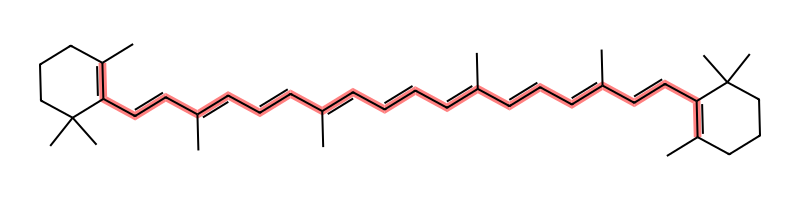

In [7]:
# Beta carotene
smiles = "CC2(C)CCCC(\C)=C2\C=C\C(\C)=C\C=C\C(\C)=C\C=C\C=C(/C)\C=C\C=C(/C)\C=C\C1=C(/C)CCCC1(C)C"
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)

Draw.MolToImage(
    mol,
    highlightBonds=longest_conjugated_bond_chain,
    size=(800, 200),
    )

## Prepare data

In [8]:
df = pl.read_csv("../data/DB for chromophore_Sci_Data_rev02.csv")

In [9]:
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
1,"""N#Cc1cc2ccc(O)cc2oc1=O""","""O""",355.0,410.0,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.1537,"""DOI: 10.1021/acs.jpcb.5b09905"""
2,"""N#Cc1cc2ccc([O-])cc2oc1=O""","""O""",408.0,450.0,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,"""DOI: 10.1021/acs.jpcb.5b09905"""
3,"""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","""ClC(Cl)Cl""",526.0,535.0,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,"""https://doi.org/10.1002/smll.2…"
4,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CC#N""",514.0,553.72,3.81,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,"""https://doi.org/10.1016/j.snb.…"
5,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CS(C)=O""",524.0,555.0,4.7,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,"""https://doi.org/10.1016/j.snb.…"


TODO Use E = hc/lambda to calculate ev_nm value from physical constants

In [10]:
@latexify.function
def E(h: float, c: float, λ: float) -> float:
    """Calculate the binomial coefficient: how many ways there are to choose k items from n items
    :param n: the number of items to choose from
    :param k: the number of items to choose
    :returns: the number of ways there are to choose k items from n items
    """
    return h * c / λ

E

Values from [KMLabs Inc](https://www.kmlabs.com/en/wavelength-to-photon-energy-calculator)

In [11]:
h = 6.6261e-34 # J*s
c = 2.9979e8 # m/s
nm = 1e-9 # m
eV = 1.602176634e-19 # J
eV_nm = h * c / (nm * eV)
eV_nm

1239.83740421969

Convert absorption and emission maxima to energy units of eV, then calculate their difference as the Stokes shift

In [12]:
def conjugated_chains(sml):
    return_dict = dict()
    mol = Chem.MolFromSmiles(sml)
    longest_bond_indices = get_longest_conjugated_bond_chain(mol)
    length = len(longest_bond_indices)
    return_dict["longest_bond_length"]=length
    return return_dict

In [13]:
for column in ["longest_bond_indices", "length", "Absorption max (eV)", "Emission max (eV)", "Stokes shift (eV)"]:
   try:
      df.drop(column)
   except:
      pass

In [14]:
df = df.with_columns(
    [
        (eV_nm / pl.col("Absorption max (nm)")).alias("Absorption max (eV)"),
        (eV_nm / pl.col("Emission max (nm)")).alias("Emission max (eV)"),
        ]
).with_columns(
        (pl.col("Absorption max (eV)") - pl.col("Emission max (eV)")).alias("Stokes shift (eV)"),
)

In [15]:
# This may take 30 seconds
df = df.with_columns(
   conjugated = pl.col('Chromophore').map_elements(lambda sml: conjugated_chains(sml), return_dtype=pl.Struct)
).unnest('conjugated').sort(pl.col("longest_bond_length"), descending=True).shrink_to_fit()

TODO restore plot of all molecules of absorption (and emission?) max against number of conjugated bonds, to show that the general rule that there's a correlation doesn't work very well for a diverse set of molecules?

In [16]:
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,Absorption max (eV),Emission max (eV),Stokes shift (eV),longest_bond_length
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,i64
15095,"""c1ccc(C(=C(c2ccccc2)c2ccc(-c3c…","""Cc1ccccc1""",530.0,637.0,NaN,0.252,NaN,NaN,NaN,NaN,NaN,1762.28448,"""https://doi.org/10.1016/j.dyep…",2.339316,1.94637,0.392946,158
15096,"""c1ccc(C(=C(c2ccccc2)c2ccc(-c3c…","""ClCCl""",520.0,647.0,6.7,0.093,NaN,NaN,NaN,NaN,NaN,1762.28448,"""https://doi.org/10.1016/j.dyep…",2.384303,1.916287,0.468016,158
5658,"""c1ccc(-n2c(-c3ccc(N(c4ccc(-c5c…","""ClCCl""",376.0,432.0,1.68,0.206,NaN,NaN,NaN,60.4,62.7,1657.99344,"""https://doi.org/10.1016/j.orge…",3.29744,2.869994,0.427446,155
5659,"""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…","""ClCCl""",376.0,435.0,1.68,0.282,NaN,NaN,NaN,61.2,62.1,1714.10096,"""https://doi.org/10.1016/j.orge…",3.29744,2.850201,0.447239,155
5660,"""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…","""ClCCl""",377.0,430.0,3.8,0.451,NaN,NaN,NaN,69.9,57.5,1882.42352,"""https://doi.org/10.1016/j.orge…",3.288693,2.883343,0.405351,155


Let's find a simple, linear molecule with a repeat unit that we can look for analogues with fewer repeat units

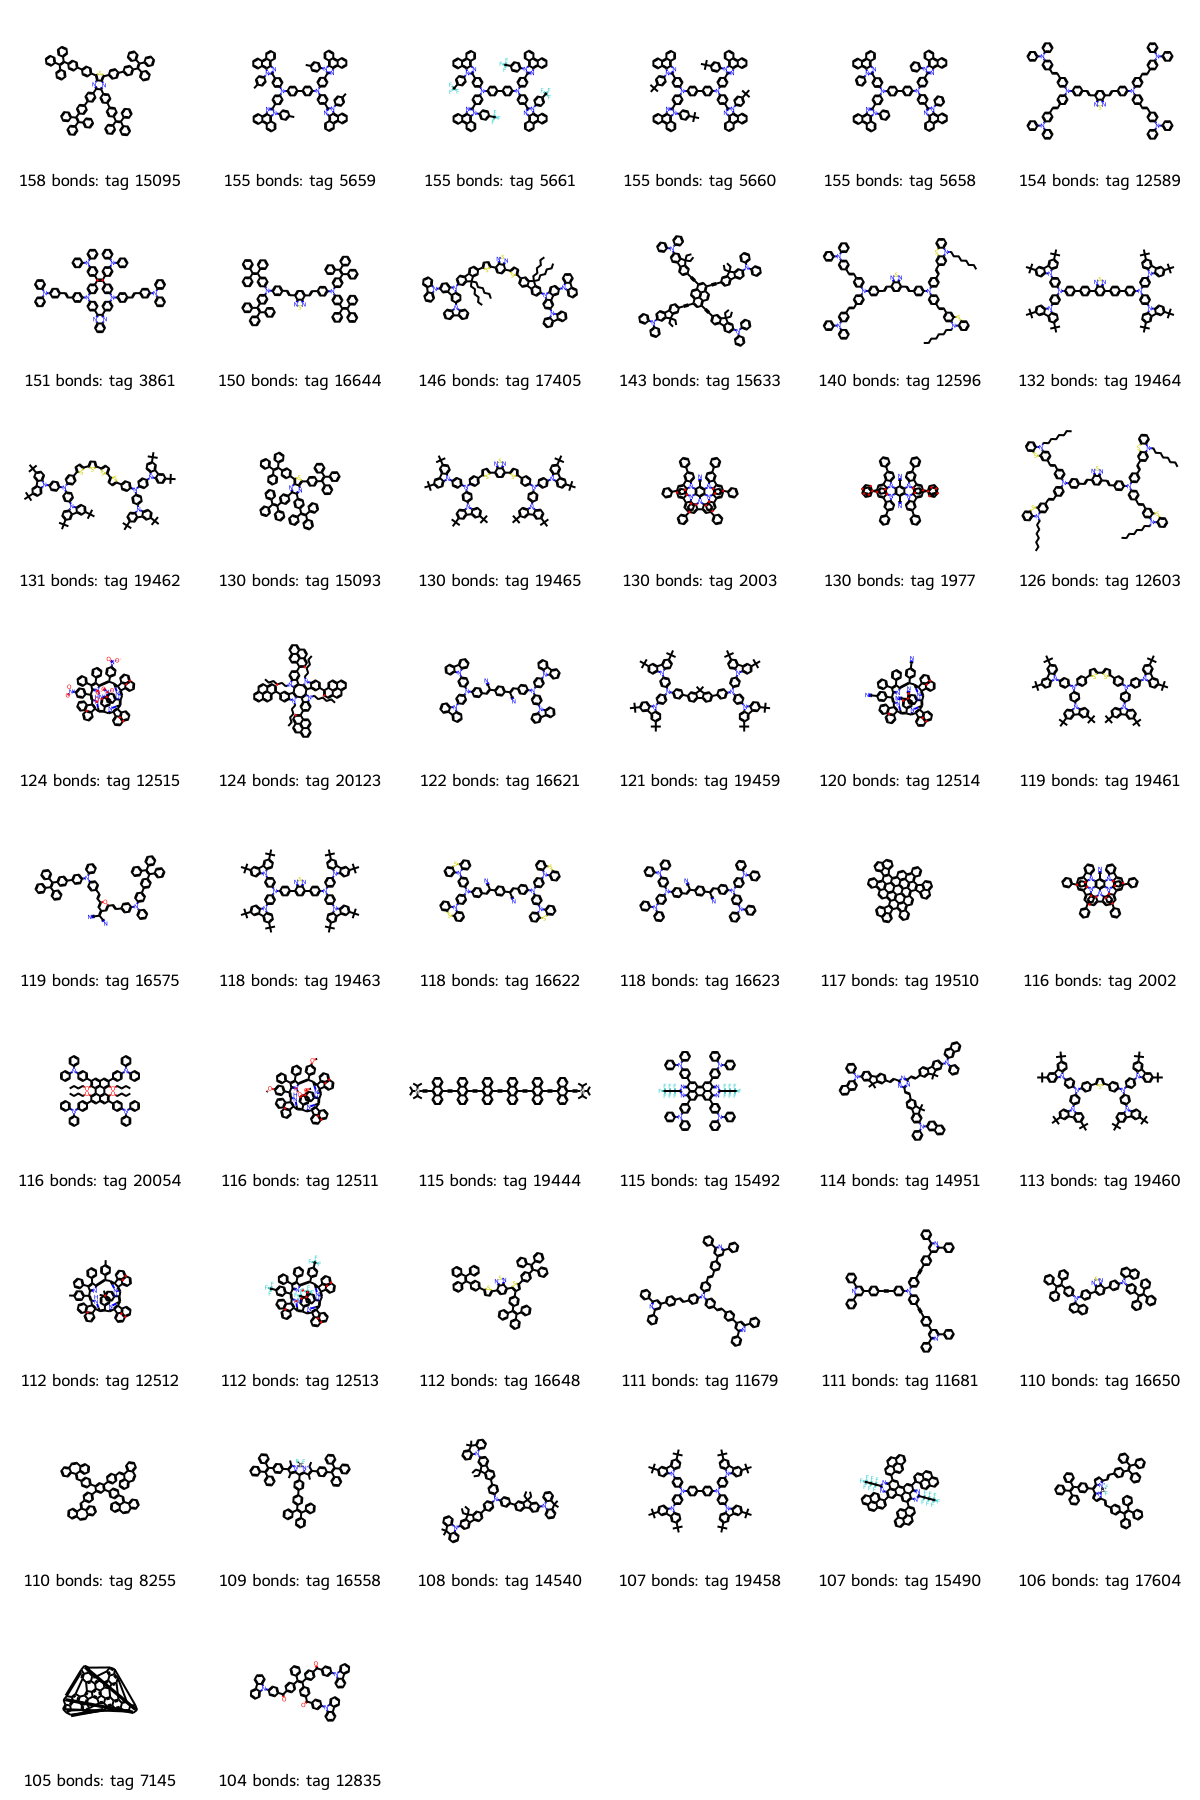

In [17]:
df_unique_chromophore = df.unique(subset="Chromophore").sort("longest_bond_length", descending=True)
matching = df_unique_chromophore["Chromophore"].to_list()
tags = df_unique_chromophore["Tag"].to_list()
longest_bond_lengths = df_unique_chromophore["longest_bond_length"].to_list()
legends = [f"{longest_bond_length} bonds: tag {tag}" for (tag, longest_bond_length) in zip(tags, longest_bond_lengths)]
mols = [Chem.MolFromSmiles(match) for match in matching]
num_compounds = 50
Draw.MolsToGridImage(
    mols = mols[:num_compounds],
    legends = legends[:num_compounds],
    molsPerRow = 6,
    )

While there are a lot of interesting-looking molecules, tag 19444 has a simple linear structure with a clear repeat unit. (To put the repeat unit in the same orientation as the molecule, we rotate the atoms of the repeat unit by 90 degrees.)

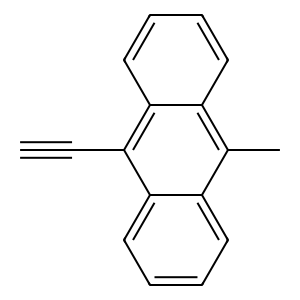

In [18]:
repeat_unit = "CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12"
repeat_unit_mol = Chem.MolFromSmiles(repeat_unit)

# Generate 2D coordinates if they are not already present
AllChem.Compute2DCoords(repeat_unit_mol)

# Define the rotation matrix for 90 degrees (π/2 radians)
theta = np.pi / 2  # 90 degrees in radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])

# Get the conformation of the molecule (the 2D coordinates)
conf = repeat_unit_mol.GetConformer()

# Apply the rotation to each atom
for i in range(repeat_unit_mol.GetNumAtoms()):
    # Get the current x, y, z coordinates (z will stay 0.0 for 2D)
    pos = conf.GetAtomPosition(i)
    x, y = pos.x, pos.y  # Extract x, y coordinates
    
    # Apply the 90-degree rotation
    new_x, new_y = np.dot(rotation_matrix, [x, y])
    
    # Set the new coordinates, keeping z=0.0
    conf.SetAtomPosition(i, (new_x, new_y, 0.0))
    
Draw.MolToImage(
    repeat_unit_mol,
    )

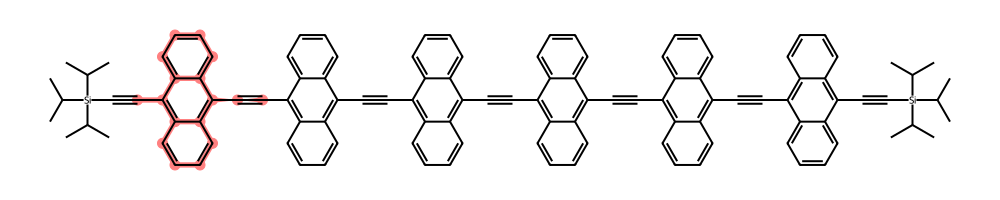

In [19]:
df_19444 = df_unique_chromophore.filter(Tag=19444)
sml_19444 = df_19444[0]["Chromophore"].item()
mol_19444 = Chem.MolFromSmiles(sml_19444)
matches = mol_19444.GetSubstructMatches(repeat_unit_mol)
Draw.MolsToGridImage(
    [mol_19444],
    highlightAtomLists=matches[::-1],
    subImgSize=(1000,200),
    molsPerRow=1,
)

Let's check the dataframe for molecules with the same overall structure and fewer repeat units.

## Filter to selected molecule series

In [20]:
def mol_props(sml, smls_to_match:Iterable[str]=None):
    """
    Convert SMILES to an RDKit molecule, then calculate various properties of it
    :returns: dictionary of molecular properties
    :param sml: SMILES to convert to a molecule
    :param sml: SMILES to convert to a molecule
    """
    mol = Chem.MolFromSmiles(sml)
    return_dict = dict()
    for name, sml_to_match in smls_to_match.items():
        mol_to_match = Chem.MolFromSmiles(sml_to_match)
        matches = mol.GetSubstructMatches(mol_to_match)
        return_dict[f"{name}_match_count"] = len(matches)
    return return_dict

TODO
- highlight each match criterion on one of the six molecules in the series?

To prevent double-counting of the number of repeat units, we use a substructure one atom longer.

In [21]:
smls_to_match = {
   "repeat_unit": "C#CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12",
   # Triisopropylsyl terminal
   "terminal": "CC(C)[SiH](C(C)C)C(C)C",
   # Four benzene rings
   "too_many_rings": "C#CC1=C2C=C3C=CC=CC3=CC2=C(C#C)C2=CC=CC=C12",
   # Four rings: Three benzene and one dinitrogen ring
   "too_many_rings_N": "C#CC1=C2C=C3N=CC=NC3=CC2=C(C#C)C2=CC=CC=C12",
   }

The substructures we want to include are in the top row, and those we want to exclude are in the bottom row.

In [22]:
def rotate_90(mol):
    # Generate 2D coordinates if they are not already present
    AllChem.Compute2DCoords(repeat_unit_mol)

    # Define the rotation matrix for 90 degrees (π/2 radians)
    theta = np.pi / 2  # 90 degrees in radians
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])

    # Get the conformation of the molecule (the 2D coordinates)
    conf = repeat_unit_mol.GetConformer()

    # Apply the rotation to each atom
    for i in range(repeat_unit_mol.GetNumAtoms()):
        # Get the current x, y, z coordinates (z will stay 0.0 for 2D)
        pos = conf.GetAtomPosition(i)
        x, y = pos.x, pos.y  # Extract x, y coordinates
        
        # Apply the 90-degree rotation
        new_x, new_y = np.dot(rotation_matrix, [x, y])
        
        # Set the new coordinates, keeping z=0.0
        conf.SetAtomPosition(i, (new_x, new_y, 0.0))
        print(f"{x, y} -> {new_x, new_y}")

TODO Make rotate_90 work--maybe it needs to return the mol object?? 

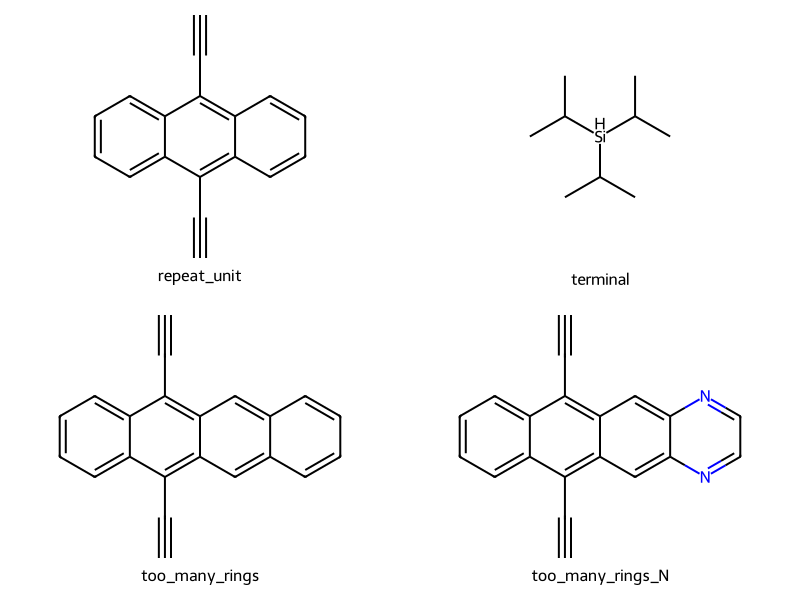

In [23]:
mols_to_match = [Chem.MolFromSmiles(sml) for sml in smls_to_match.values()]
mols_to_match[0]
for mol in mols_to_match:
    # rotate_90(mol)
    # Generate 2D coordinates if they are not already present
    AllChem.Compute2DCoords(repeat_unit_mol)

    # Define the rotation matrix for 90 degrees (π/2 radians)
    theta = np.pi / 2  # 90 degrees in radians
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])

    # Get the conformation of the molecule (the 2D coordinates)
    conf = repeat_unit_mol.GetConformer()

    # Apply the rotation to each atom
    for i in range(repeat_unit_mol.GetNumAtoms()):
        # Get the current x, y, z coordinates (z will stay 0.0 for 2D)
        pos = conf.GetAtomPosition(i)
        x, y = pos.x, pos.y  # Extract x, y coordinates
        
        # Apply the 90-degree rotation
        new_x, new_y = np.dot(rotation_matrix, [x, y])
        
        # Set the new coordinates, keeping z=0.0
        conf.SetAtomPosition(i, (new_x, new_y, 0.0))

# mol
# Draw.MolToImage(mol)
Draw.MolsToGridImage(
    mols = mols_to_match,
    legends = smls_to_match.keys(),
    molsPerRow = 2,
    subImgSize = (400, 300)
    )

In [24]:
df = df.drop(cs.ends_with("_match_count"))

In [25]:
df = df.with_columns(
   molecular_props = pl.col('Chromophore').map_elements(lambda sml: mol_props(sml, smls_to_match), return_dtype=pl.Struct)
).unnest('molecular_props').sort("longest_bond_length", descending=True).shrink_to_fit()
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,Absorption max (eV),Emission max (eV),Stokes shift (eV),longest_bond_length,repeat_unit_match_count,terminal_match_count,too_many_rings_match_count,too_many_rings_N_match_count
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,i64,i64,i64,i64,i64
15095,"""c1ccc(C(=C(c2ccccc2)c2ccc(-c3c…","""Cc1ccccc1""",530.0,637.0,NaN,0.252,NaN,NaN,NaN,NaN,NaN,1762.28448,"""https://doi.org/10.1016/j.dyep…",2.339316,1.94637,0.392946,158,0,0,0,0
15096,"""c1ccc(C(=C(c2ccccc2)c2ccc(-c3c…","""ClCCl""",520.0,647.0,6.7,0.093,NaN,NaN,NaN,NaN,NaN,1762.28448,"""https://doi.org/10.1016/j.dyep…",2.384303,1.916287,0.468016,158,0,0,0,0
5658,"""c1ccc(-n2c(-c3ccc(N(c4ccc(-c5c…","""ClCCl""",376.0,432.0,1.68,0.206,NaN,NaN,NaN,60.4,62.7,1657.99344,"""https://doi.org/10.1016/j.orge…",3.29744,2.869994,0.427446,155,0,0,0,0
5659,"""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…","""ClCCl""",376.0,435.0,1.68,0.282,NaN,NaN,NaN,61.2,62.1,1714.10096,"""https://doi.org/10.1016/j.orge…",3.29744,2.850201,0.447239,155,0,0,0,0
5660,"""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…","""ClCCl""",377.0,430.0,3.8,0.451,NaN,NaN,NaN,69.9,57.5,1882.42352,"""https://doi.org/10.1016/j.orge…",3.288693,2.883343,0.405351,155,0,0,0,0


In [43]:
def df_to_grid_image(
        df,
        subImgSize = (200, 200),
        molsPerRow = 3,
        ):
    matching = df["Chromophore"].to_list()
    mols = [Chem.MolFromSmiles(match) for match in matching]
    num_match = df["repeat_unit_match_count"].to_list()
    absorbance_nm = df["Absorption max (nm)"].to_list()
    legends = []
    for index in range(len(num_match)):
        legend = f"{num_match[index]} unit(s)"
        abs_nm = absorbance_nm[index]
        if not math.isnan(abs_nm):
            legend += f" {abs_nm}nm"
        legends.append(legend)
    conjugated_bonds = [get_longest_conjugated_bond_chain(mol) for mol in mols]
    dwg = Draw.MolsToGridImage(
        mols = mols,
        legends = legends,
        maxMols = 10,
        molsPerRow = molsPerRow,
        highlightBondLists = conjugated_bonds,
        subImgSize = subImgSize,
    )
    print(f"{len(mols)} molecules")
    return dwg

Let's filter down to molecules that match with the repeat unit.

51 molecules


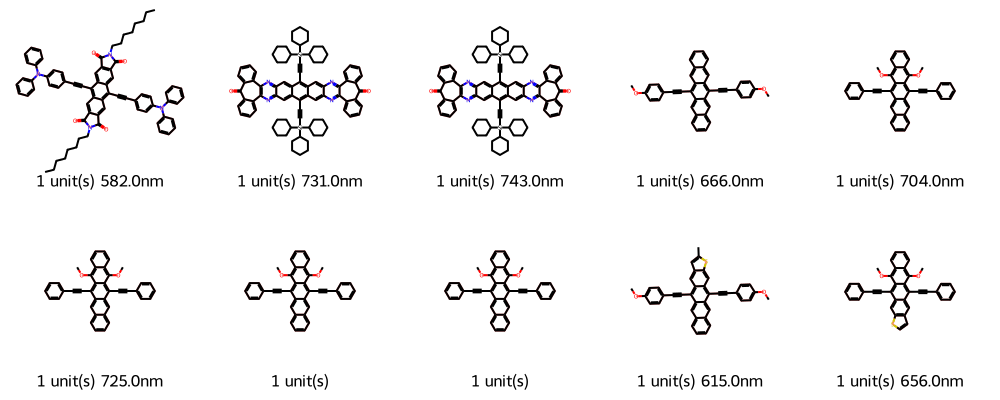

In [29]:
df_to_grid_image(df.filter(
    (pl.col("repeat_unit_match_count") > 0)
        ).sort(pl.col("repeat_unit_match_count")))

Hmm, we get too many, and none of the first 10 have the two terminal triisopropylsyl terminal. Let's specify that we want two terminal groups.

19 molecules


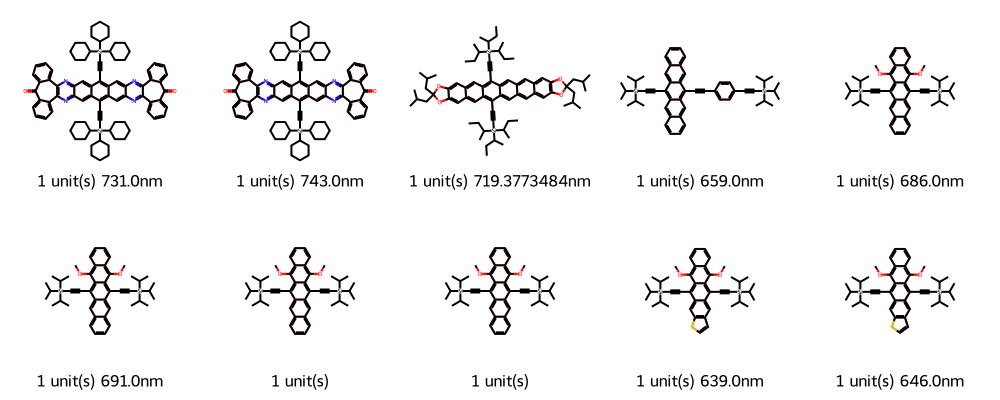

In [28]:
df_to_grid_image(df.filter(
    (pl.col("repeat_unit_match_count") > 0) & (
        pl.col("terminal_match_count") == 2)
            ).sort(pl.col("repeat_unit_match_count")))

That helps, but we're getting a lot of fused-ring systems with more than three rings. Let's exclude those.

6 molecules


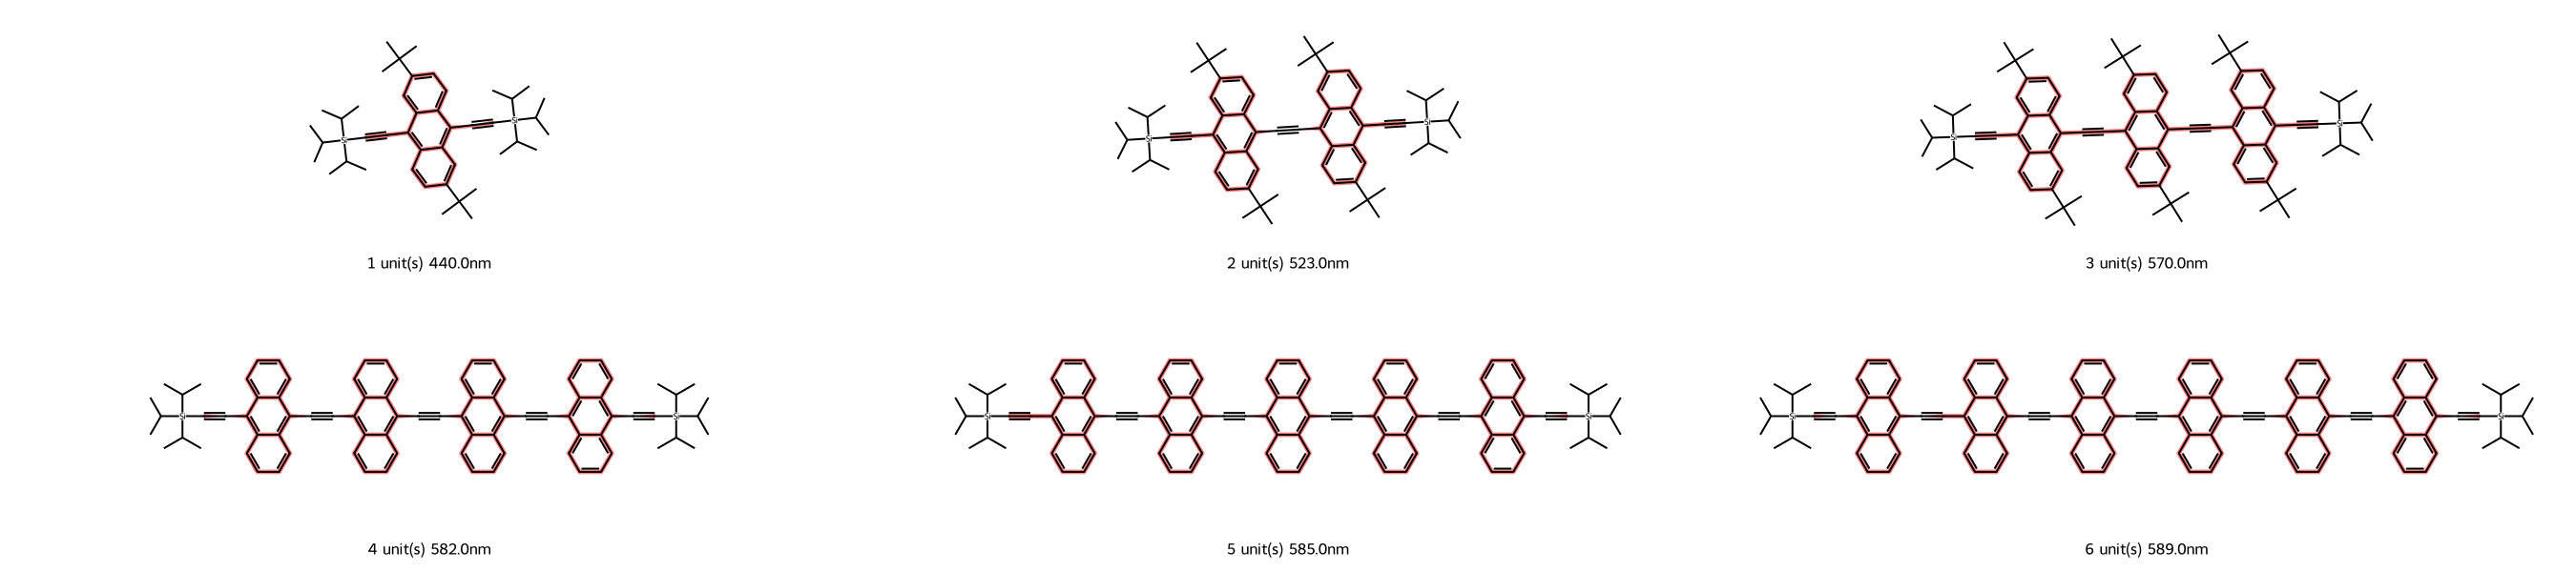

In [47]:
# Filter down to a set of reasonably consistent structures where repeat unit count varies
df_matches = df.filter(
    (pl.col("repeat_unit_match_count") > 0) & (
        pl.col("terminal_match_count") == 2) & (
            pl.col("too_many_rings_match_count") == 0) & (
                pl.col("too_many_rings_N_match_count") == 0
            )
        ).sort(pl.col("repeat_unit_match_count"))
df_to_grid_image(
    df_matches,
    subImgSize = (900, 300),
    molsPerRow = 3,
    )

Those criteria are sufficient to get just the set of molecules we want. If we had a larger dataset, we might have to add more criteria to exclude closer matches.

In [30]:
df_matches

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,Absorption max (eV),Emission max (eV),Stokes shift (eV),longest_bond_length,repeat_unit_match_count,terminal_match_count,too_many_rings_match_count,too_many_rings_N_match_count
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,i64,i64,i64,i64,i64
19439,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",440.0,461.0,NaN,0.92,4.4133,NaN,NaN,NaN,NaN,651.18004,"""DOI: 10.1021/acs.joc.8b00311""",2.817812,2.689452,0.12836,20,1,2,0,0
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2.370626,2.291751,0.078875,39,2,2,0,0
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",2.175153,2.104987,0.070166,58,3,2,0,0
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",2.130305,2.035858,0.094447,77,4,2,0,0
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""",2.11938,1.990108,0.129272,96,5,2,0,0
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""",2.104987,1.971125,0.133862,115,6,2,0,0


In [31]:
matching = df_matches["Chromophore"].to_list()
mols = [Chem.MolFromSmiles(match) for match in matching]
num_match = df_matches["repeat_unit_match_count"].to_list()
absorbance_nm = df_matches["Absorption max (nm)"].to_list()
legends = []
for index in range(len(num_match)):
    legends.append(f"{num_match[index]} unit(s): {absorbance_nm[index]}nm")
df_matches

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,Absorption max (eV),Emission max (eV),Stokes shift (eV),longest_bond_length,repeat_unit_match_count,terminal_match_count,too_many_rings_match_count,too_many_rings_N_match_count
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,i64,i64,i64,i64,i64
19439,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",440.0,461.0,NaN,0.92,4.4133,NaN,NaN,NaN,NaN,651.18004,"""DOI: 10.1021/acs.joc.8b00311""",2.817812,2.689452,0.12836,20,1,2,0,0
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""",2.370626,2.291751,0.078875,39,2,2,0,0
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""",2.175153,2.104987,0.070166,58,3,2,0,0
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""",2.130305,2.035858,0.094447,77,4,2,0,0
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""",2.11938,1.990108,0.129272,96,5,2,0,0
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""",2.104987,1.971125,0.133862,115,6,2,0,0


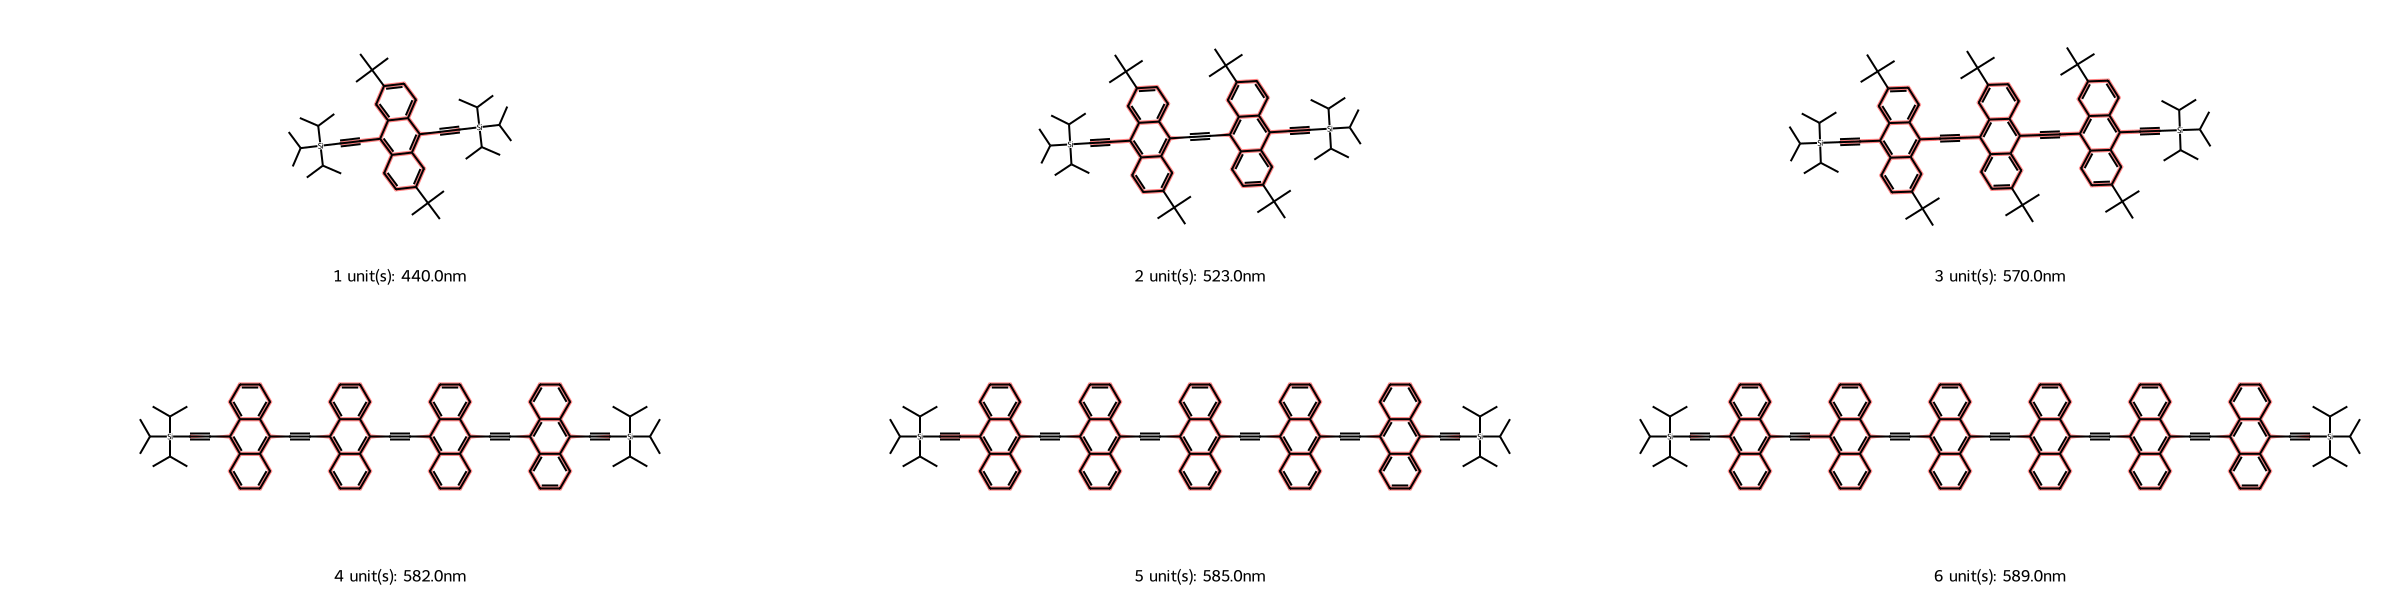

In [32]:
conjugated_bonds = [get_longest_conjugated_bond_chain(mol) for mol in mols]
Draw.MolsToGridImage(
    mols = mols,
    legends = legends,
    subImgSize=(800, 300),
    maxMols = 100,
    highlightBondLists = conjugated_bonds,
)

## Plot results

In [33]:
# Set color scheme
absorption_color = 'blue'
emission_color = 'red'
delta_color = 'orange'

In [34]:
# Calculate the minimum and maximum y-value in nm across both series
min_y_value = min(df_matches['Absorption max (nm)'].min(), df_matches['Emission max (nm)'].min())
y_min = min_y_value * 0.95  # Adjust to 95% of the minimum value for a slight buffer
max_y_value = max(df_matches['Absorption max (nm)'].max(), df_matches['Emission max (nm)'].max())
y_max = max_y_value * 1.05  # Adjust to 105% of the maximum value for a slight buffer

# Calculate the minimum and maximum y-value in eV across both series
min_y_value_eV = min(df_matches['Absorption max (eV)'].min(), df_matches['Emission max (eV)'].min())
y_min_eV = min_y_value_eV * 0.95  # Adjust to 95% of the minimum value for a slight buffer
max_y_value_eV = max(df_matches['Absorption max (eV)'].max(), df_matches['Emission max (eV)'].max())
y_max_eV = max_y_value_eV * 1.05  # Adjust to 105% of the maximum value for a slight buffer

# Calculate the maximum x-value
max_x_value = df_matches['repeat_unit_match_count'].max() + 0.5

In [35]:
# First scatter plot for "Absorption max (nm)"
scatter_absorption = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Absorption max (nm)',
    color=alt.value(absorption_color),
    tooltip=['repeat_unit_match_count', 'Absorption max (nm)']
).properties(
    title="Absorption max"
)

# Second scatter plot for "Emission max (nm)"
scatter_emission = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y='Emission max (nm)',
    color=alt.value(emission_color),
    tooltip=['repeat_unit_match_count', 'Emission max (nm)']
).properties(
    title="Emission max"
)

# Create a manual legend using Polars
legend_data = pl.DataFrame({
    'Type': ['Absorption max (nm)', 'Emission max (nm)'],
    'Color': [absorption_color, emission_color]
})

legend = alt.Chart(legend_data).mark_point(size=100).encode(
    y=alt.Y('Type:N', axis=alt.Axis(orient='right')),
    color=alt.Color('Color:N', scale=None)
)

# Combine the scatter plot and legend
scatter_combined = alt.layer(
    scatter_absorption, scatter_emission
).properties(
    title='Absorption and Emission Max Scatter Plot'
).encode(
    y=alt.Y('Absorption max (nm)', scale=alt.Scale(domain=[y_min, y_max]), title="Absorption and emission max (nm)"),
    x=alt.X('repeat_unit_match_count', scale=alt.Scale(domain=[0.5, max_x_value]), title="# repeat units")
).interactive()

# Display the chart with the legend
layered_chart = alt.hconcat(scatter_combined, legend)

layered_chart.show()

alt.HConcatChart(...)

In [36]:
delta_y_max = df_matches['Stokes shift (eV)'].max() * 1.1

In [37]:
# First scatter plot for "Absorption max (eV)" and "Emission max (eV)" (upper part of the y-axis)
scatter_absorption = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y=alt.Y('Absorption max (eV)', scale=alt.Scale(domain=[y_min_eV, y_max_eV])),
    color=alt.value(absorption_color),
    tooltip=['repeat_unit_match_count', 'Absorption max (eV)']
)

scatter_emission = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y=alt.Y('Emission max (eV)', scale=alt.Scale(domain=[y_min_eV, y_max_eV])),  # Same y-axis range as absorption
    color=alt.value(emission_color),
    tooltip=['repeat_unit_match_count', 'Emission max (eV)']
)

# Second scatter plot for "Stokes shift (eV)" (lower part of the y-axis)
scatter_delta = alt.Chart(df_matches).mark_point().encode(
    x='repeat_unit_match_count',
    y=alt.Y('Stokes shift (eV)', scale=alt.Scale(domain=[0, delta_y_max])),  # Delta on a different y-axis range
    color=alt.value('orange'),
    tooltip=['repeat_unit_match_count', 'Stokes shift (eV)']
)

# Manual legend with explicit sort order
legend_data = pl.DataFrame({
    'Type': ['Absorption max (eV)', 'Emission max (eV)', 'Stokes shift (eV)'],
    'Color': [absorption_color, emission_color, 'orange']
})

legend = alt.Chart(legend_data).mark_point(size=100).encode(
    y=alt.Y('Type:N', sort=['Absorption max (eV)', 'Emission max (eV)', 'Stokes shift (eV)'],  # Explicit sort order
            axis=alt.Axis(orient='right', title=None)),
    color=alt.Color('Color:N', scale=None)
).properties(
    width=50
)

# Layer the two scatter plots, but apply y-axis breaks by separating ranges
upper_chart = alt.layer(
    scatter_absorption, scatter_emission
).encode(
    y=alt.Y(
        'Absorption max (eV)', 
        scale=alt.Scale(domain=[y_min_eV, y_max_eV]), 
        title="Absorption or emission max (eV)"
    ),
    x=alt.X(
        'repeat_unit_match_count', 
        scale=alt.Scale(domain=[0.5, max_x_value]), 
        title=None,
        axis=alt.Axis(labels=False, tickSize=0),
    )
)

lower_chart = scatter_delta.encode(
    y=alt.Y(
        'Stokes shift (eV)', 
        scale=alt.Scale(domain=[0, delta_y_max]), 
        title="Stokes shift (eV)"
    ),
    x=alt.X(
        'repeat_unit_match_count', 
        scale=alt.Scale(domain=[0.5, max_x_value]), 
        title="# Repeat Units"
    )
)

# Combine the two charts vertically with some padding to simulate a break
combined_chart = alt.vconcat(
    upper_chart.properties(height=300),
    lower_chart.properties(height=100),
    spacing=10  # Add space between charts to simulate axis break
).resolve_scale(
    x='shared'
)

# Display the combined chart with the legend
layered_chart = alt.hconcat(combined_chart, legend)

layered_chart.show()

alt.HConcatChart(...)

In all cases, the solvent is toluene.

TODO
- Discuss Stokes shift and pattern
- Discuss why fluorescence quantum yield is high for n = 1, then low for n > 1